Processing timestep 13
Number of clouds detected: 325


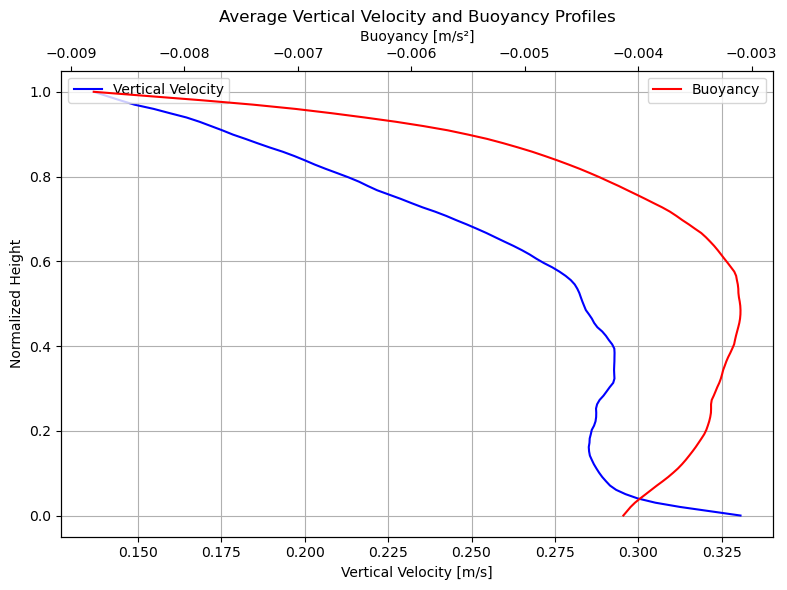

In [11]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import label
from scipy.interpolate import interp1d

liquid_water_threshold = 1e-5  # Threshold for liquid water content

data_dir = '/Users/jure/PhD/coding/RICO_1hr/'

files = {
    'w': data_dir + 'rico.w.nc',
    'l': data_dir + 'rico.l.nc',
    'q': data_dir + 'rico.q.nc',
    't': data_dir + 'rico.t.nc',
    'p': data_dir + 'rico.p.nc',
    'theta': data_dir + 'rico.potential_temp.nc',
    'b': data_dir + 'rico.buoyancy.nc'  # Add buoyancy file
}

var_names = {
    'w': 'w',
    'l': 'l',
    'q': 'q',
    't': 't',
    'theta': 'potential_temperature',
    'b': 'buoyancy'  # Buoyancy variable name
}

def load_data(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        return ds[var_name][timestep].astype(np.float64)

def load_zt(filename):
    with nc.Dataset(filename) as ds:
        return ds['zt'][:]

def process_clouds_over_time(start_timestep, end_timestep):
    """
    Identifies clouds, computes average vertical velocity and buoyancy profiles,
    and normalizes cloud heights.
    """
    # Common normalized height grid (from 0 to 1)
    norm_height_grid = np.linspace(0, 1, num=100)

    # Lists to store interpolated profiles
    w_profiles = []
    b_profiles = []  # For buoyancy

    # Load height values
    zt_values = load_zt(files['l'])

    for t in range(start_timestep, end_timestep):
        print(f"Processing timestep {t}")
        # Load data for the current timestep
        w_data = load_data(files['w'], var_names['w'], t)  # Vertical velocity
        l_data = load_data(files['l'], var_names['l'], t)  # Liquid water content
        b_data = load_data(files['b'], var_names['b'], t)  # Buoyancy

        # Create the cloudy mask based on liquid water threshold
        cloudy = l_data > liquid_water_threshold  # Boolean array of shape (z, y, x)

        # Label connected components in 3D to identify individual clouds
        labeled_array, num_features = label(cloudy)

        print(f"Number of clouds detected: {num_features}")

        # Process each cloud individually
        for i in range(1, num_features + 1):
            # Create a mask for the current cloud
            cloud_mask = labeled_array == i  # Boolean mask for cloud i

            # Get the indices of the cloud points
            z_indices, y_indices, x_indices = np.where(cloud_mask)

            # Skip clouds that span less than 2 vertical levels
            if len(np.unique(z_indices)) < 2:
                continue

            # Initialize lists to store heights and averages
            heights = []
            w_means = []
            b_means = []  # Buoyancy means

            # Process each vertical level within the cloud
            unique_z_indices = np.unique(z_indices)
            for z in unique_z_indices:
                # Mask for points at this level within the cloud
                level_mask = (z_indices == z)

                # Get the y and x indices at this level
                y_level = y_indices[level_mask]
                x_level = x_indices[level_mask]

                # Extract values at these points
                w_values = w_data[z, y_level, x_level]
                b_values = b_data[z, y_level, x_level]

                # Compute the averages at this level
                w_mean = np.mean(w_values)
                b_mean = np.mean(b_values)

                # Store the height and averages
                heights.append(zt_values[z])
                w_means.append(w_mean)
                b_means.append(b_mean)

            # Convert lists to numpy arrays
            heights = np.array(heights)
            w_means = np.array(w_means)
            b_means = np.array(b_means)

            # Sort the heights and corresponding values
            sort_indices = np.argsort(heights)
            heights = heights[sort_indices]
            w_means = w_means[sort_indices]
            b_means = b_means[sort_indices]

            # Normalize the heights from 0 to 1
            if heights[-1] - heights[0] == 0:
                continue  # Skip clouds with zero height extent

            norm_heights = (heights - heights[0]) / (heights[-1] - heights[0])

            # Interpolate the cloud's profiles onto the common normalized height grid
            interp_func_w = interp1d(norm_heights, w_means, kind='linear', bounds_error=False, fill_value=np.nan)
            interp_func_b = interp1d(norm_heights, b_means, kind='linear', bounds_error=False, fill_value=np.nan)
            w_interp = interp_func_w(norm_height_grid)
            b_interp = interp_func_b(norm_height_grid)

            # Store the interpolated profiles
            w_profiles.append(w_interp)
            b_profiles.append(b_interp)

    # After processing all clouds, convert lists to numpy arrays
    w_profiles = np.array(w_profiles)  # Shape: (num_clouds, num_norm_heights)
    b_profiles = np.array(b_profiles)  # Shape: (num_clouds, num_norm_heights)

    # Compute the average profiles at each normalized height, ignoring NaNs
    w_mean_profile = np.nanmean(w_profiles, axis=0)
    b_mean_profile = np.nanmean(b_profiles, axis=0)

    return norm_height_grid, w_mean_profile, b_mean_profile

# Time range
start_timestep = 13
end_timestep = 14  # Adjust as needed

# Process clouds and compute average vertical velocity and buoyancy profiles
norm_height_grid, w_mean_profile, b_mean_profile = process_clouds_over_time(start_timestep, end_timestep)

# Plotting the average profiles on the same figure
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot vertical velocity on the left y-axis
ax1.plot(w_mean_profile, norm_height_grid, label='Vertical Velocity', color='blue')
ax1.set_xlabel('Vertical Velocity [m/s]')
ax1.set_ylabel('Normalized Height')
ax1.set_title('Average Vertical Velocity and Buoyancy Profiles')
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a secondary axis for buoyancy
ax2 = ax1.twiny()
ax2.plot(b_mean_profile, norm_height_grid, label='Buoyancy', color='red')
ax2.set_xlabel('Buoyancy [m/s²]')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


Processing timestep 10
Processing timestep 11
Processing timestep 12
Processing timestep 13


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_23308/1746818227.py:172: RuntimeWarning: Mean of empty slice
  "w": np.nanmean(w_profiles, axis=0),
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_23308/1746818227.py:173: RuntimeWarning: Mean of empty slice
  "b": np.nanmean(b_profiles, axis=0),


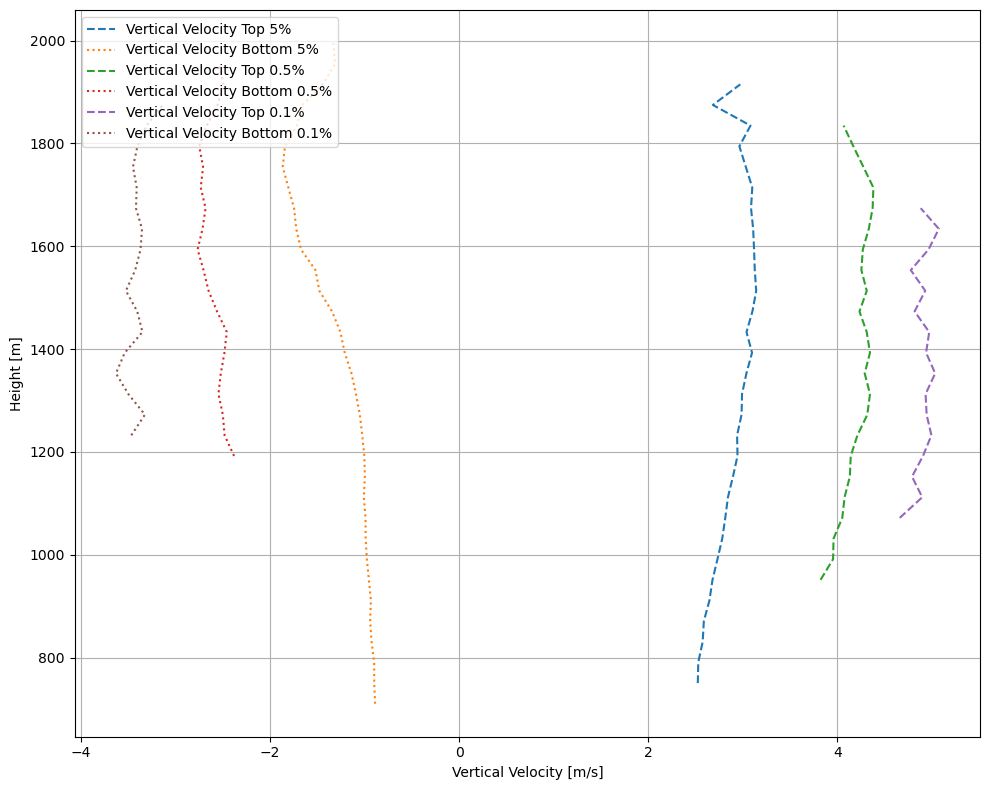

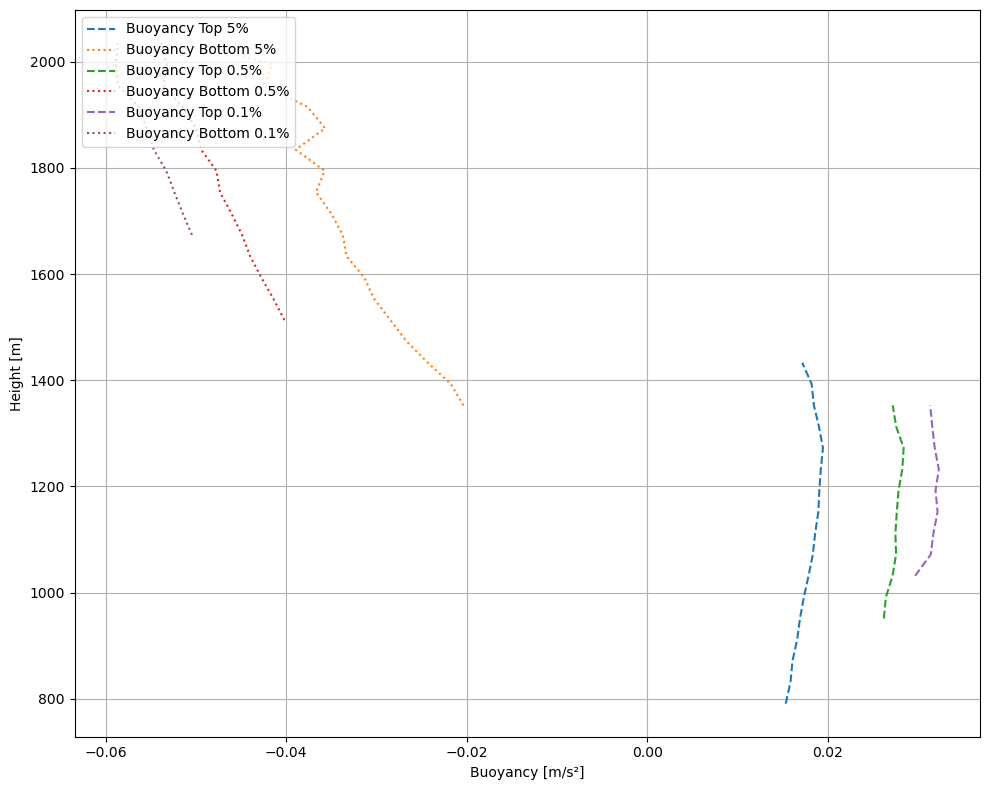

In [19]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import label
from scipy.interpolate import interp1d

liquid_water_threshold = 1e-5  # Threshold for liquid water content

data_dir = '/Users/jure/PhD/coding/RICO_1hr/'

files = {
    'w': data_dir + 'rico.w.nc',
    'l': data_dir + 'rico.l.nc',
    'q': data_dir + 'rico.q.nc',
    't': data_dir + 'rico.t.nc',
    'p': data_dir + 'rico.p.nc',
    'theta': data_dir + 'rico.potential_temp.nc',
    'b': data_dir + 'rico.buoyancy.nc'  # Add buoyancy file
}

var_names = {
    'w': 'w',
    'l': 'l',
    'q': 'q',
    't': 't',
    'theta': 'potential_temperature',
    'b': 'buoyancy'  # Buoyancy variable name
}

def load_data(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        return ds[var_name][timestep].astype(np.float64)

def load_zt(filename):
    with nc.Dataset(filename) as ds:
        return ds['zt'][:]

def calculate_percentiles(data, liquid_water_mask, percentiles):
    """
    Calculate the thresholds for the given percentiles (both top and bottom)
    based on the data values where liquid water content exceeds the threshold.
    """
    # Apply the liquid water mask
    masked_data = data[liquid_water_mask]

    # Calculate the thresholds for the requested percentiles
    thresholds = {}
    for p in percentiles:
        thresholds[f"top_{p}"] = np.percentile(masked_data, 100 - p)
        thresholds[f"bottom_{p}"] = np.percentile(masked_data, p)
    
    return thresholds

def process_clouds_over_time(start_timestep, end_timestep, percentiles):
    """
    Identifies clouds, computes average vertical velocity and buoyancy profiles,
    and computes profiles for top/bottom percentiles.
    """
    # Load height values
    zt_values = load_zt(files['l'])

    # Define a common height grid (from minimum to maximum height)
    common_height_grid = np.linspace(zt_values[0], zt_values[-1], num=100)

    # Lists to store interpolated profiles for each percentile category
    percentile_profiles = {f"top_{p}": [] for p in percentiles}
    percentile_profiles.update({f"bottom_{p}": [] for p in percentiles})

    for t in range(start_timestep, end_timestep):
        print(f"Processing timestep {t}")
        # Load data for the current timestep
        w_data = load_data(files['w'], var_names['w'], t)  # Vertical velocity
        l_data = load_data(files['l'], var_names['l'], t)  # Liquid water content
        b_data = load_data(files['b'], var_names['b'], t)  # Buoyancy

        # Create the liquid water mask
        liquid_water_mask = l_data > liquid_water_threshold

        # Calculate the thresholds for top and bottom percentiles
        w_thresholds = calculate_percentiles(w_data, liquid_water_mask, percentiles)
        b_thresholds = calculate_percentiles(b_data, liquid_water_mask, percentiles)

        # Label connected components in 3D to identify individual clouds
        labeled_array, num_features = label(liquid_water_mask)

        # Process each cloud individually
        for i in range(1, num_features + 1):
            # Create a mask for the current cloud
            cloud_mask = labeled_array == i  # Boolean mask for cloud i

            # Get the indices of the cloud points
            z_indices, y_indices, x_indices = np.where(cloud_mask)

            # Skip clouds that span less than 2 vertical levels
            if len(np.unique(z_indices)) < 2:
                continue

            # Initialize lists to store heights and averages
            heights = []
            percentile_values = {key: [] for key in percentile_profiles}

            # Process each vertical level within the cloud
            unique_z_indices = np.unique(z_indices)
            for z in unique_z_indices:
                # Mask for points at this level within the cloud
                level_mask = (z_indices == z)

                # Get the y and x indices at this level
                y_level = y_indices[level_mask]
                x_level = x_indices[level_mask]

                # Extract values at these points
                w_values = w_data[z, y_level, x_level]
                b_values = b_data[z, y_level, x_level]

                # Filter values based on thresholds for each percentile category
                for p in percentiles:
                    top_w_mask = w_values >= w_thresholds[f"top_{p}"]
                    bottom_w_mask = w_values <= w_thresholds[f"bottom_{p}"]
                    top_b_mask = b_values >= b_thresholds[f"top_{p}"]
                    bottom_b_mask = b_values <= b_thresholds[f"bottom_{p}"]

                    # Compute mean values, handle empty arrays
                    top_w_mean = np.mean(w_values[top_w_mask]) if np.any(top_w_mask) else np.nan
                    bottom_w_mean = np.mean(w_values[bottom_w_mask]) if np.any(bottom_w_mask) else np.nan
                    top_b_mean = np.mean(b_values[top_b_mask]) if np.any(top_b_mask) else np.nan
                    bottom_b_mean = np.mean(b_values[bottom_b_mask]) if np.any(bottom_b_mask) else np.nan

                    percentile_values[f"top_{p}"].append(
                        (top_w_mean, top_b_mean)
                    )
                    percentile_values[f"bottom_{p}"].append(
                        (bottom_w_mean, bottom_b_mean)
                    )

                heights.append(zt_values[z])

            # Convert lists to numpy arrays
            heights = np.array(heights)

            # Skip clouds with zero height extent
            if len(heights) < 2 or (heights[-1] - heights[0]) == 0:
                continue

            # Ensure heights and profiles are sorted
            sorted_indices = np.argsort(heights)
            heights = heights[sorted_indices]

            for key in percentile_profiles.keys():
                w_profile = np.array([pair[0] for pair in percentile_values[key]])[sorted_indices]
                b_profile = np.array([pair[1] for pair in percentile_values[key]])[sorted_indices]

                # Interpolate the profiles onto the common height grid
                interp_func_w = interp1d(
                    heights, w_profile, kind="linear", bounds_error=False, fill_value=np.nan
                )
                interp_func_b = interp1d(
                    heights, b_profile, kind="linear", bounds_error=False, fill_value=np.nan
                )
                percentile_profiles[key].append(
                    (interp_func_w(common_height_grid), interp_func_b(common_height_grid))
                )

    # Convert lists to numpy arrays and compute the mean profiles
    mean_profiles = {}
    for key, profiles in percentile_profiles.items():
        if profiles:
            w_profiles, b_profiles = zip(*profiles)
            w_profiles = np.array(w_profiles)
            b_profiles = np.array(b_profiles)
            mean_profiles[key] = {
                "w": np.nanmean(w_profiles, axis=0),
                "b": np.nanmean(b_profiles, axis=0),
            }
        else:
            mean_profiles[key] = {
                "w": np.full_like(common_height_grid, np.nan),
                "b": np.full_like(common_height_grid, np.nan),
            }

    return common_height_grid, mean_profiles

# Time range
start_timestep = 10
end_timestep = 14  # Adjust as needed

# Percentiles to analyze
percentiles = [5, 0.5, 0.1]

# Process clouds and compute profiles
common_height_grid, mean_profiles = process_clouds_over_time(start_timestep, end_timestep, percentiles)

# Plotting the average vertical velocity profiles
fig_w, ax_w = plt.subplots(figsize=(10, 8))

# Plot vertical velocity profiles
for p in percentiles:
    ax_w.plot(mean_profiles[f"top_{p}"]["w"], common_height_grid, label=f"Vertical Velocity Top {p}%", linestyle="--")
    ax_w.plot(mean_profiles[f"bottom_{p}"]["w"], common_height_grid, label=f"Vertical Velocity Bottom {p}%", linestyle=":")

ax_w.set_xlabel("Vertical Velocity [m/s]")
ax_w.set_ylabel("Height [m]")
ax_w.grid(True)
ax_w.legend(loc="upper left")

plt.tight_layout()
plt.show()

# Plotting the average buoyancy profiles
fig_b, ax_b = plt.subplots(figsize=(10, 8))

# Plot buoyancy profiles
for p in percentiles:
    ax_b.plot(mean_profiles[f"top_{p}"]["b"], common_height_grid, label=f"Buoyancy Top {p}%", linestyle="--")
    ax_b.plot(mean_profiles[f"bottom_{p}"]["b"], common_height_grid, label=f"Buoyancy Bottom {p}%", linestyle=":")

ax_b.set_xlabel("Buoyancy [m/s²]")
ax_b.set_ylabel("Height [m]")
ax_b.grid(True)
ax_b.legend(loc="upper left")

plt.tight_layout()
plt.show()


Processing timestep 4
Processing timestep 5
Processing timestep 6
Processing timestep 7
Processing timestep 8
Processing timestep 9
Processing timestep 10
Processing timestep 11
Processing timestep 12
Processing timestep 13


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_23308/79549560.py:172: RuntimeWarning: Mean of empty slice
  "w": np.nanmean(w_profiles, axis=0),
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_23308/79549560.py:173: RuntimeWarning: Mean of empty slice
  "b": np.nanmean(b_profiles, axis=0),


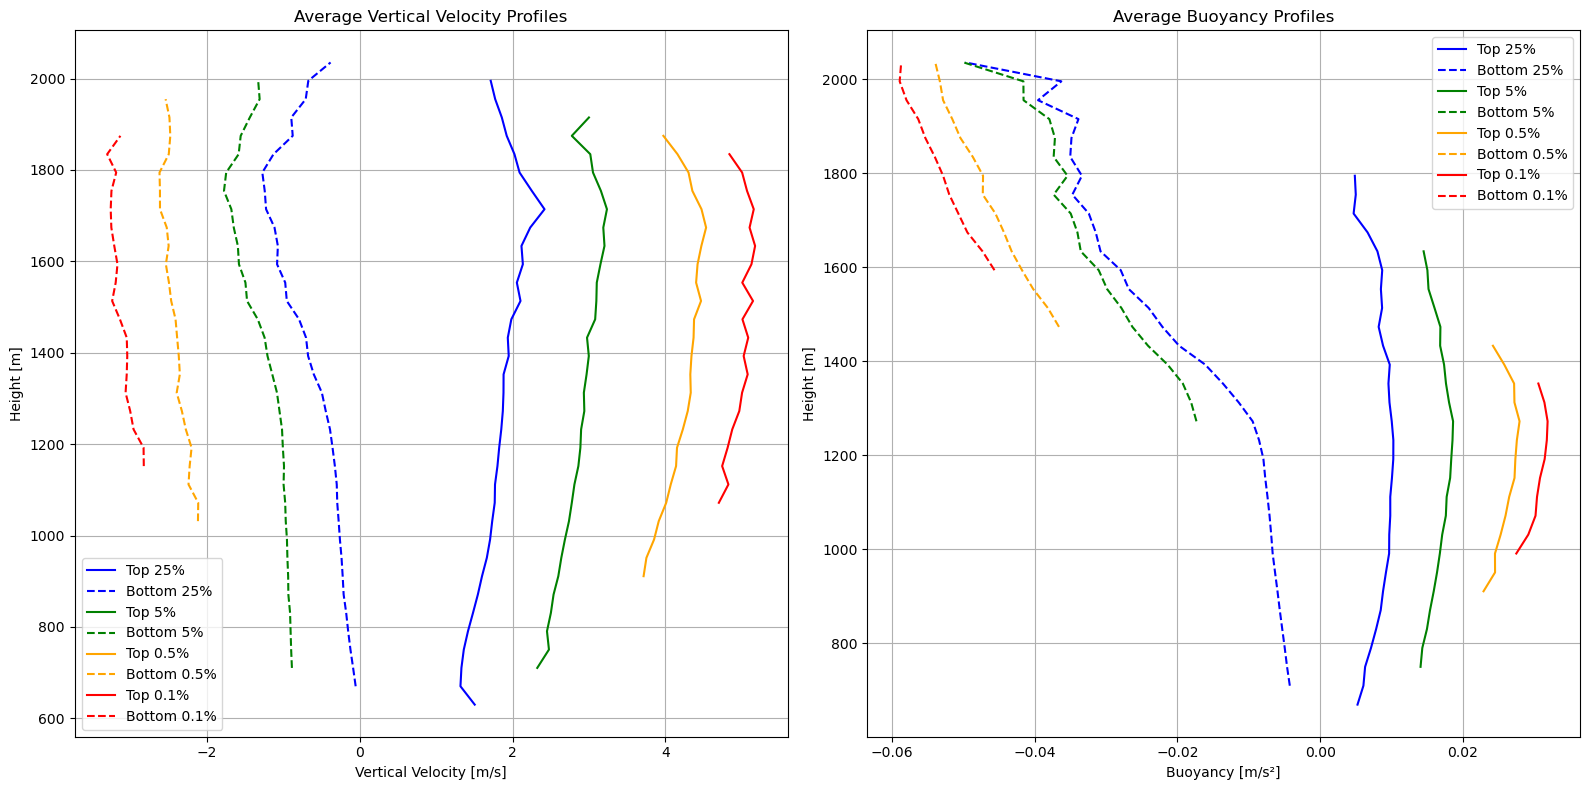

In [39]:
# import numpy as np
# import netCDF4 as nc
# import matplotlib.pyplot as plt
# from scipy.ndimage import label
# from scipy.interpolate import interp1d

# liquid_water_threshold = 1e-5  # Threshold for liquid water content

# data_dir = '/Users/jure/PhD/coding/RICO_1hr/'

# files = {
#     'w': data_dir + 'rico.w.nc',
#     'l': data_dir + 'rico.l.nc',
#     'q': data_dir + 'rico.q.nc',
#     't': data_dir + 'rico.t.nc',
#     'p': data_dir + 'rico.p.nc',
#     'theta': data_dir + 'rico.potential_temp.nc',
#     'b': data_dir + 'rico.buoyancy.nc'  # Add buoyancy file
# }

# var_names = {
#     'w': 'w',
#     'l': 'l',
#     'q': 'q',
#     't': 't',
#     'theta': 'potential_temperature',
#     'b': 'buoyancy'  # Buoyancy variable name
# }

# def load_data(filename, var_name, timestep):
#     with nc.Dataset(filename) as ds:
#         return ds[var_name][timestep].astype(np.float64)

# def load_zt(filename):
#     with nc.Dataset(filename) as ds:
#         return ds['zt'][:]

# def calculate_percentiles(data, liquid_water_mask, percentiles):
#     """
#     Calculate the thresholds for the given percentiles (both top and bottom)
#     based on the data values where liquid water content exceeds the threshold.
#     """
#     # Apply the liquid water mask
#     masked_data = data[liquid_water_mask]

#     # Calculate the thresholds for the requested percentiles
#     thresholds = {}
#     for p in percentiles:
#         thresholds[f"top_{p}"] = np.percentile(masked_data, 100 - p)
#         thresholds[f"bottom_{p}"] = np.percentile(masked_data, p)
    
#     return thresholds

# def process_clouds_over_time(start_timestep, end_timestep, percentiles):
#     """
#     Identifies clouds, computes average vertical velocity and buoyancy profiles,
#     and computes profiles for top/bottom percentiles.
#     """
#     # Load height values
#     zt_values = load_zt(files['l'])

#     # Define a common height grid (from minimum to maximum height)
#     common_height_grid = np.linspace(zt_values[0], zt_values[-1], num=100)

#     # Lists to store interpolated profiles for each percentile category
#     percentile_profiles = {f"top_{p}": [] for p in percentiles}
#     percentile_profiles.update({f"bottom_{p}": [] for p in percentiles})

#     for t in range(start_timestep, end_timestep):
#         print(f"Processing timestep {t}")
#         # Load data for the current timestep
#         w_data = load_data(files['w'], var_names['w'], t)  # Vertical velocity
#         l_data = load_data(files['l'], var_names['l'], t)  # Liquid water content
#         b_data = load_data(files['b'], var_names['b'], t)  # Buoyancy

#         # Create the liquid water mask
#         liquid_water_mask = l_data > liquid_water_threshold

#         # Calculate the thresholds for top and bottom percentiles
#         w_thresholds = calculate_percentiles(w_data, liquid_water_mask, percentiles)
#         b_thresholds = calculate_percentiles(b_data, liquid_water_mask, percentiles)

#         # Label connected components in 3D to identify individual clouds
#         labeled_array, num_features = label(liquid_water_mask)

#         # Process each cloud individually
#         for i in range(1, num_features + 1):
#             # Create a mask for the current cloud
#             cloud_mask = labeled_array == i  # Boolean mask for cloud i

#             # Get the indices of the cloud points
#             z_indices, y_indices, x_indices = np.where(cloud_mask)

#             # Skip clouds that span less than 2 vertical levels
#             if len(np.unique(z_indices)) < 2:
#                 continue

#             # Initialize lists to store heights and averages
#             heights = []
#             percentile_values = {key: [] for key in percentile_profiles}

#             # Process each vertical level within the cloud
#             unique_z_indices = np.unique(z_indices)
#             for z in unique_z_indices:
#                 # Mask for points at this level within the cloud
#                 level_mask = (z_indices == z)

#                 # Get the y and x indices at this level
#                 y_level = y_indices[level_mask]
#                 x_level = x_indices[level_mask]

#                 # Extract values at these points
#                 w_values = w_data[z, y_level, x_level]
#                 b_values = b_data[z, y_level, x_level]

#                 # Filter values based on thresholds for each percentile category
#                 for p in percentiles:
#                     top_w_mask = w_values >= w_thresholds[f"top_{p}"]
#                     bottom_w_mask = w_values <= w_thresholds[f"bottom_{p}"]
#                     top_b_mask = b_values >= b_thresholds[f"top_{p}"]
#                     bottom_b_mask = b_values <= b_thresholds[f"bottom_{p}"]

#                     # Compute mean values, handle empty arrays
#                     top_w_mean = np.mean(w_values[top_w_mask]) if np.any(top_w_mask) else np.nan
#                     bottom_w_mean = np.mean(w_values[bottom_w_mask]) if np.any(bottom_w_mask) else np.nan
#                     top_b_mean = np.mean(b_values[top_b_mask]) if np.any(top_b_mask) else np.nan
#                     bottom_b_mean = np.mean(b_values[bottom_b_mask]) if np.any(bottom_b_mask) else np.nan

#                     percentile_values[f"top_{p}"].append(
#                         (top_w_mean, top_b_mean)
#                     )
#                     percentile_values[f"bottom_{p}"].append(
#                         (bottom_w_mean, bottom_b_mean)
#                     )

#                 heights.append(zt_values[z])

#             # Convert lists to numpy arrays
#             heights = np.array(heights)

#             # Skip clouds with zero height extent
#             if len(heights) < 2 or (heights[-1] - heights[0]) == 0:
#                 continue

#             # Ensure heights and profiles are sorted
#             sorted_indices = np.argsort(heights)
#             heights = heights[sorted_indices]

#             for key in percentile_profiles.keys():
#                 w_profile = np.array([pair[0] for pair in percentile_values[key]])[sorted_indices]
#                 b_profile = np.array([pair[1] for pair in percentile_values[key]])[sorted_indices]

#                 # Interpolate the profiles onto the common height grid
#                 interp_func_w = interp1d(
#                     heights, w_profile, kind="linear", bounds_error=False, fill_value=np.nan
#                 )
#                 interp_func_b = interp1d(
#                     heights, b_profile, kind="linear", bounds_error=False, fill_value=np.nan
#                 )
#                 percentile_profiles[key].append(
#                     (interp_func_w(common_height_grid), interp_func_b(common_height_grid))
#                 )

#     # Convert lists to numpy arrays and compute the mean profiles
#     mean_profiles = {}
#     for key, profiles in percentile_profiles.items():
#         if profiles:
#             w_profiles, b_profiles = zip(*profiles)
#             w_profiles = np.array(w_profiles)
#             b_profiles = np.array(b_profiles)
#             mean_profiles[key] = {
#                 "w": np.nanmean(w_profiles, axis=0),
#                 "b": np.nanmean(b_profiles, axis=0),
#             }
#         else:
#             mean_profiles[key] = {
#                 "w": np.full_like(common_height_grid, np.nan),
#                 "b": np.full_like(common_height_grid, np.nan),
#             }

#     return common_height_grid, mean_profiles

# # Time range
# start_timestep = 13
# end_timestep = 14  # Adjust as needed

# # Percentiles to analyze
# percentiles = [25, 5, 0.5, 0.1]

# # Process clouds and compute profiles
# common_height_grid, mean_profiles = process_clouds_over_time(start_timestep, end_timestep, percentiles)

# # Define colors for each percentile
# colors = {
#     25: 'blue',
#     5: 'green',
#     0.5: 'orange',
#     0.1: 'red'
# }

# # Plotting the average vertical velocity and buoyancy profiles side by side
# fig, (ax_w, ax_b) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# # Plot vertical velocity profiles on the first subplot
# for p in percentiles:
#     color = colors[p]
#     ax_w.plot(mean_profiles[f"top_{p}"]["w"], common_height_grid, label=f"Top {p}%", color=color, linestyle='-')
#     ax_w.plot(mean_profiles[f"bottom_{p}"]["w"], common_height_grid, label=f"Bottom {p}%", color=color, linestyle='--')

# ax_w.set_xlabel("Vertical Velocity [m/s]")
# ax_w.set_ylabel("Height [m]")
# ax_w.grid(True)
# ax_w.legend(loc="best")
# ax_w.set_title("Average Vertical Velocity Profiles")

# # Plot buoyancy profiles on the second subplot
# for p in percentiles:
#     color = colors[p]
#     ax_b.plot(mean_profiles[f"top_{p}"]["b"], common_height_grid, label=f"Top {p}%", color=color, linestyle='-')
#     ax_b.plot(mean_profiles[f"bottom_{p}"]["b"], common_height_grid, label=f"Bottom {p}%", color=color, linestyle='--')

# ax_b.set_xlabel("Buoyancy [m/s²]")
# ax_b.set_ylabel("Height [m]")
# ax_b.grid(True)
# ax_b.legend(loc="best")
# ax_b.set_title("Average Buoyancy Profiles")
# #fig.savefig('w_and_B_vertical_percentiles.pdf', format='pdf', bbox_inches='tight')
# plt.tight_layout()
# plt.show()
